다운받은 '050.페르소나 기반의 가상 인물 몽타주 데이터' 폴더 - Training - 원천데이터 - TS의 montage Image와 Json 파일 활용

1. 데이터 전처리

In [14]:
import os
from PIL import Image
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd

Train Data

In [15]:
#사용할 데이터가 있는 위치로 이동 (Train)
%cd C:/Users/ebsic/OneDrive/문서/개발/안면인식프로젝트/050.페르소나 기반의 가상 인물 몽타주 데이터/01.데이터/1.Training/원천데이터_221205_add/TS/

C:\Users\ebsic\OneDrive\문서\개발\안면인식프로젝트\050.페르소나 기반의 가상 인물 몽타주 데이터\01.데이터\1.Training\원천데이터_221205_add\TS


In [16]:
imgs_path = 'Images/montage/'
labels_path = 'json/H/'

In [17]:
len(os.listdir(imgs_path)),len(os.listdir(labels_path))

(8071, 8071)

In [18]:
imgs_list = os.listdir(imgs_path)
labels_list = os.listdir(labels_path)


In [23]:
#Resize & Padding 함수 정의

def padding(img, set_size):

    try:
        h,w,c = img.shape
    except:
        print('파일을 확인후 다시 시작하세요.')
        raise

    if h < w:
        new_width = set_size
        new_height = int(new_width * (h/w))
    else:
        new_height = set_size
        new_width = int(new_height * (w/h))

    if max(h, w) < set_size:
        img = cv2.resize(img, (new_width, new_height), cv2.INTER_CUBIC)
    else:
        img = cv2.resize(img, (new_width, new_height), cv2.INTER_AREA)

 
    try:
        h,w,c = img.shape
    except:
        print('파일을 확인후 다시 시작하세요.')
        raise

    delta_w = set_size - w
    delta_h = set_size - h
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return new_img

In [24]:
json_sample = pd.read_json(labels_path + '/' + labels_list[0], encoding='cp949')
json_sample.iloc[9]['description']['type']

'직모(생머리)'

In [25]:
imgs_list[0]

'100.png'

In [62]:
hair_dic = {'직모(생머리)':0,'곱슬머리':1,'웨이브형':2,'스포츠형':3,'탈모형':4, '민머리':4}
hair_dic_reverse = {0:'직모(생머리)',1:'곱슬머리',2:'웨이브형',3:'스포츠형',4:'탈모형'}

In [28]:
x_train = []
y_train = []
for i in tqdm(range(len(imgs_list))) :
  img = cv2.imread(imgs_path+imgs_list[i], cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pad_img = padding(img,416)
  x_train.append(pad_img)
  
  hair = pd.read_json(labels_path + imgs_list[i][:-4] + '.json', encoding='cp949').iloc[9]['description']['type']
  hair_index = hair_dic[hair]
  y_train.append(hair_index)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape, y_train.shape

100%|██████████| 8071/8071 [00:56<00:00, 141.76it/s]


((8071, 416, 416, 3), (8071,))

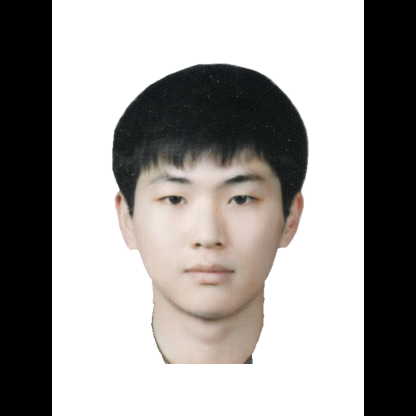

In [29]:
Image.fromarray(x_train[0])

TEST DATA

In [30]:
#사용할 데이터가 있는 위치로 이동 (Test)
%cd C:/Users/ebsic/OneDrive/문서/개발/안면인식프로젝트/050.페르소나 기반의 가상 인물 몽타주 데이터/01.데이터/2.Validation/원천데이터_221205_add/VS

C:\Users\ebsic\OneDrive\문서\개발\안면인식프로젝트\050.페르소나 기반의 가상 인물 몽타주 데이터\01.데이터\2.Validation\원천데이터_221205_add\VS


In [31]:

test_imgs_path = 'Images/montage/'
test_labels_path = 'json/H/'

len(os.listdir(test_imgs_path)),len(os.listdir(test_labels_path))

(1010, 1010)

In [32]:
test_imgs_list = os.listdir(test_imgs_path)
test_labels_list = os.listdir(test_labels_path)

In [35]:
x_test = []
y_test = []
for i in tqdm(range(len(test_imgs_list))) :
  img = cv2.imread(test_imgs_path+test_imgs_list[i], cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pad_img = padding(img,416)
  x_test.append(pad_img)
  
  hair = pd.read_json(test_labels_path + test_imgs_list[i][:-4] + '.json', encoding='cp949').iloc[9]['description']['type']
  hair_index = hair_dic[hair]
  y_test.append(hair_index)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_test.shape, y_test.shape

100%|██████████| 1010/1010 [00:06<00:00, 163.97it/s]


((1010, 416, 416, 3), (1010,))

In [36]:
x_train.shape

(8071, 416, 416, 3)

Zero Centering

In [37]:
def zero_mean(image):
    # zero-centering
    return np.mean(image, axis=0)

In [38]:
zero_mean_img = zero_mean(x_train)

In [39]:
zero_mean_img.shape

(416, 416, 3)

In [40]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [41]:
x_train -= zero_mean_img
x_test -= zero_mean_img

모델 학습

In [42]:
import tensorflow as tf

In [43]:
dir(tf.keras.applications)

['ConvNeXtBase',
 'ConvNeXtLarge',
 'ConvNeXtSmall',
 'ConvNeXtTiny',
 'ConvNeXtXLarge',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'RegNetX002',
 'RegNetX004',
 'RegNetX006',
 'RegNetX008',
 'RegNetX016',
 'RegNetX032',
 'RegNetX040',
 'RegNetX064',
 'RegNetX080',
 'RegNetX120',
 'RegNetX160',
 'RegNetX320',
 'RegNetY002',
 'RegNetY004',
 'RegNetY006',
 'RegNetY008',
 'RegNetY016',
 'RegNetY032',
 'RegNetY040',
 'RegNetY064',
 'RegNetY080',
 'RegNetY120',
 'RegNetY160',
 'RegNetY320',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'Re

In [44]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [45]:
from tensorflow.keras import layers, models

from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt

import datetime

In [47]:
base_model = ResNet50(include_top=False, input_shape = (416,416 ,3), weights = 'imagenet')

In [48]:
len(base_model.layers)

175

In [49]:
base_model.layers[:]

In [50]:
base_model.trainable =True
base_model.trainable

True

In [51]:
for layer in base_model.layers[:-10]: 
  layer.trainable = False				

for layer in base_model.layers[-100:]:	
  print(layer.name, layer.trainable)

conv3_block4_2_bn False
conv3_block4_2_relu False
conv3_block4_3_conv False
conv3_block4_3_bn False
conv3_block4_add False
conv3_block4_out False
conv4_block1_1_conv False
conv4_block1_1_bn False
conv4_block1_1_relu False
conv4_block1_2_conv False
conv4_block1_2_bn False
conv4_block1_2_relu False
conv4_block1_0_conv False
conv4_block1_3_conv False
conv4_block1_0_bn False
conv4_block1_3_bn False
conv4_block1_add False
conv4_block1_out False
conv4_block2_1_conv False
conv4_block2_1_bn False
conv4_block2_1_relu False
conv4_block2_2_conv False
conv4_block2_2_bn False
conv4_block2_2_relu False
conv4_block2_3_conv False
conv4_block2_3_bn False
conv4_block2_add False
conv4_block2_out False
conv4_block3_1_conv False
conv4_block3_1_bn False
conv4_block3_1_relu False
conv4_block3_2_conv False
conv4_block3_2_bn False
conv4_block3_2_relu False
conv4_block3_3_conv False
conv4_block3_3_bn False
conv4_block3_add False
conv4_block3_out False
conv4_block4_1_conv False
conv4_block4_1_bn False
conv4_bloc

In [52]:
inputs = tf.keras.Input(shape=(416, 416, 3))

x = base_model(inputs, training=False) # batchnorm 부분 update 방지

x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [53]:
model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 416, 416, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 13, 13, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 346112)            0         
                                                                 
 dense (Dense)               (None, 256)               88604928  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 112,193,925
Trainable params: 93,071,877
Non-tr

In [55]:
%cd C:/Users/ebsic/OneDrive/문서/개발/안면인식프로젝트

C:\Users\ebsic\OneDrive\문서\개발\안면인식프로젝트


In [57]:
callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0)

In [58]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, epochs = 30, validation_data=(x_test,y_test), batch_size= 32, 
          callbacks=[early,callback])

Epoch 1/30
253/253 [==============================] - 106s 380ms/step - loss: 1.2965 - accuracy: 0.6276 - val_loss: 0.7586 - val_accuracy: 0.6802 - lr: 1.0000e-04
Epoch 2/30
253/253 [==============================] - 63s 248ms/step - loss: 0.7448 - accuracy: 0.6842 - val_loss: 0.7506 - val_accuracy: 0.6911 - lr: 1.0000e-04
Epoch 3/30
253/253 [==============================] - 64s 250ms/step - loss: 0.6708 - accuracy: 0.7104 - val_loss: 0.7329 - val_accuracy: 0.6703 - lr: 1.0000e-04
Epoch 4/30
253/253 [==============================] - 53s 207ms/step - loss: 0.5954 - accuracy: 0.7475 - val_loss: 0.7335 - val_accuracy: 0.6881 - lr: 1.0000e-04
Epoch 5/30
253/253 [==============================] - 51s 200ms/step - loss: 0.4660 - accuracy: 0.8096 - val_loss: 0.7502 - val_accuracy: 0.6842 - lr: 2.0000e-05
Epoch 6/30
253/253 [==============================] - 54s 212ms/step - loss: 0.3959 - accuracy: 0.8441 - val_loss: 0.7727 - val_accuracy: 0.6851 - lr: 4.0000e-06
Epoch 7/30
253/253 [=======

Inference

In [59]:
sample_url = 'https://blog.kakaocdn.net/dn/IOYEi/btq1JzPmm2w/Jn7TB4RqutJNkyeAS8K0U1/img.jpg'

In [63]:

def inference_image(img_paht):
  sample_array = []
  os.system("curl " + sample_url + " > sample.jpg")
  sample_img = cv2.imread('sample.jpg', cv2.IMREAD_COLOR)
  sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
  pad_img = padding(sample_img,416)
  sample_array.append(pad_img)
  sample_array = np.array(sample_array)
  
  result = model.predict(sample_array)
  result = result.argmax(axis=-1)
  
  
  print("헤어 스타일은 {}입니다.".format(hair_dic_reverse[result[0]]))

  
  return pad_img
  

1/1 [==============================] - 0s 15ms/step
헤어 스타일은 직모(생머리)입니다.


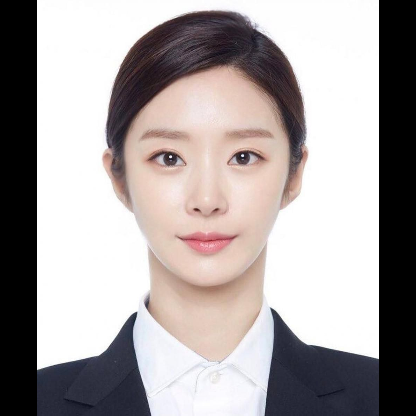

In [64]:
sample = inference_image(sample_url)
Image.fromarray(sample)
